In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as tf
from torchvision.datasets import CIFAR100

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from typing import Union, List, Dict, Any, Optional, cast
import torchvision.models.vgg as vgg

import gc

In [ ]:
#stats is used for normalization
stat1 = torch.Tensor([0.5071, 0.4865, 0.4409])
stat2 = torch.Tensor([0.2009, 0.1984, 0.2023])
stats = stat1, stat2
stats

#torchvision.transforms.Compose
train_transforms = tf.Compose([
    tf.RandomHorizontalFlip(),
    tf.RandomCrop(32, padding=4, padding_mode='reflect'),
    tf.ToTensor(),
    tf.Normalize(*stats, inplace=True)
])
test_transforms = tf.Compose([
    tf.ToTensor(),
    tf.Normalize(*stats)
])

#make custom cifar100 dataset
train_data = CIFAR100(download=True, train=True, root="../data", transform=train_transforms)
test_data = CIFAR100(download=True, train=False, root='../data', transform=test_transforms)

<h3><u><b> VGG CLASS

In [6]:
def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 3
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        
        self.features = features #Convolution layers which I'm going to design
        
        # self.avgpool = nn.AdaptiveAvgPool2d((7, 7)) #input image size is already small, so I'm not going to use AAP2d
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )#FC layer
        
        if init_weights:
            self._initialize_weights()

    
    def forward(self, x):
        x = self.features(x) #Convolution 
        x = x.view(x.size(0), -1) # flatten!
        x = self.classifier(x) #FC layer
        return x

    def _initialize_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [7]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [8]:
def train_model(_model, _epoch, _train_data_loader, _optimizer, _lr_sche, _creterion, _array_cost, _array_accu, _array_lr):
    train_cost_sum = 0
    corrects = 0
    len_dataloader = len(_train_data_loader)

    print('----------------train----------------')
    for batch_idx, data in enumerate(_train_data_loader):
        x, y = data
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        _optimizer.zero_grad()
        prediction = _model(x)
        corrects += (prediction.argmax(1) == y).sum().item()
        cost = creterion(prediction, y)
        cost.backward()
        _optimizer.step()
        _lr_sche.step()
        _array_lr.append(get_lr(_optimizer))

        train_cost_sum += cost.item()
        if (batch_idx + 1) % (len_dataloader//3) == 0:
            train_cost_avg = train_cost_sum / (batch_idx + 1)
            print('Epoch:{:2d}/{} batch_idx:{:3d} Train Cost:{:2.6f}'
            .format(_epoch + 1, TRAIN_EPOCHS, batch_idx + 1, train_cost_avg))
    
    accuracy = (corrects / len(train_data)) * 100
    print('Epoch:{:2d}/{} batch_idx:{:3d} Train Accuracy:{:2.6f}'
            .format(_epoch + 1, TRAIN_EPOCHS, batch_idx + 1, accuracy))
    _array_cost.append(train_cost_sum/len(_train_data_loader))
    _array_accu.append(accuracy)
        

In [9]:
def test_model(_model, _epoch, _test_data_loader, _creterion, _array_cost, _array_accu):
    test_cost_avg = 0
    corrects = 0
    print('----------------test----------------')
    for batch_idx, data in enumerate(_test_data_loader):
        x, y = data
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        prediction = _model(x)
        corrects += (prediction.argmax(1) == y).sum().item()
        cost = _creterion(prediction, y)
        test_cost_avg += cost.item()/len(test_data_loader)

    accuracy = (corrects / len(test_data)) * 100
    print('Epoch:{:2d}/{} Test Cost:{:2.6f} Test Accuracy:{:.4f}'
            .format(_epoch, TRAIN_EPOCHS, test_cost_avg, accuracy))
    _array_cost.append(test_cost_avg)
    _array_accu.append(accuracy)

    return test_cost_avg, accuracy

In [ ]:
BATCH_SIZE = 128
train_data_loader = torch.utils.data.DataLoader(train_data, BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True, drop_last=True)
test_data_loader = torch.utils.data.DataLoader(test_data, BATCH_SIZE, num_workers=4, pin_memory=True)

print('train data set shape', len(train_data))
print('test data set shape', len(test_data))

for data in train_data_loader:
    x, y = data
    print('x shape', x.shape)
    print('y shape', y.shape)

    break
train_iteration = len(train_data)/BATCH_SIZE

print('data_loader length', len(train_data_loader))

<h4><b><u> Dictionary for model's layer configuration

In [11]:
cfgs = { 
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], #8(conv) + 3(fc) =11 == vgg11
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], # 10 + 3 = vgg 13
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], #13 + 3 = vgg 16
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'], # 16 +3 =vgg 19
    'custom19' : [32,32,64,64,128,128,128,'M',256,256,256,256,256,'M',512, 512, 512,512,'M']
}

In [ ]:
DEVICE = 'cuda:0'    #if you can't use GPU edit as 'cpu'
LEARNING_RATE = 1e-2
TRAIN_EPOCHS = 120
cfg = 'custom19'
nb_layer = cfg[-2:]

model = VGG(features=make_layers(cfgs[cfg]), num_classes=100, init_weights=True)
model = model.to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=(len(train_data_loader)*10), gamma=0.8)
creterion = nn.CrossEntropyLoss().to(DEVICE)
train_cost_arr = []
train_accu_arr = []
train_lr_arr = []
test_cost_arr = []
test_accu_arr = []
x_array = []

for epoch in range(TRAIN_EPOCHS):
    x_array.append(epoch + 1)
    train_cost_sum = 0
    test_cost_avg = 0

    model.train()
    train_model(model, epoch, train_data_loader, optimizer, lr_sche, creterion, train_cost_arr, train_accu_arr, train_lr_arr)
    
    model.eval()
    test_model(model, epoch, test_data_loader, creterion, test_cost_arr, test_accu_arr)

    #ploting graphs per one epoch 
    plt.subplot(1,2,1)
    plt.plot(x_array, train_cost_arr, 'r', label='train cost')
    plt.plot(x_array, test_cost_arr, 'g', label='test cost')
    plt.xlabel('EPOCH')
    plt.ylabel('Cost')
    plt.title('Train(r)/Test(g) Cost vs Epoch')
    
    plt.subplot(1,2,2)
    plt.plot(x_array, train_accu_arr, 'r', label='train accu')
    plt.plot(x_array, test_accu_arr, 'g', label='test accu')
    plt.xlabel('EPOCH')
    plt.ylabel('ACCURACY')
    plt.title('Train(r)/Test(g) ACCURACY vs Epoch')
    
    plt.rcParams["figure.figsize"] = (17,5)
    plt.rcParams['axes.grid'] = True 
    plt.show()

    #plot lr graph per one Epoch
    # plt.plot([x for x in range(len(train_lr_arr))], train_lr_arr, 'b', label='lr per iteration')
    # plt.xlabel('Iteration')
    # plt.ylabel('Learning Rate')
    # plt.title('LR per Iteration')
    # plt.show()


torch.save(model, '../trained_models/vgg{}_epoch{}_accuLB{:2.2f}|{:2.2f}.pt'.format(nb_layer, TRAIN_EPOCHS, test_accu_arr[-1], max(test_accu_arr)))

<h4><b><u>Plot last graph

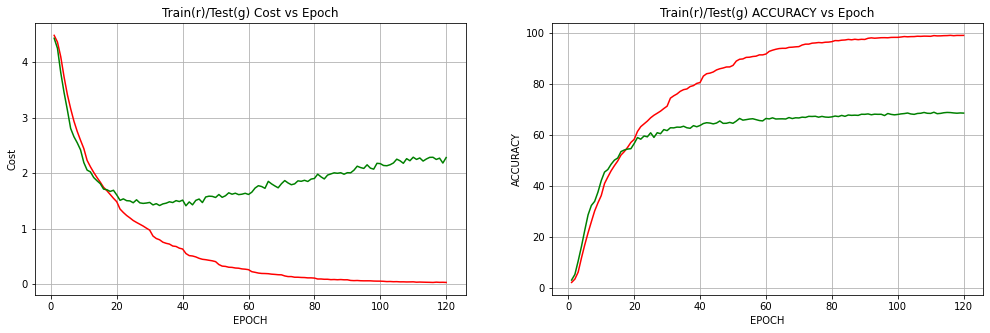

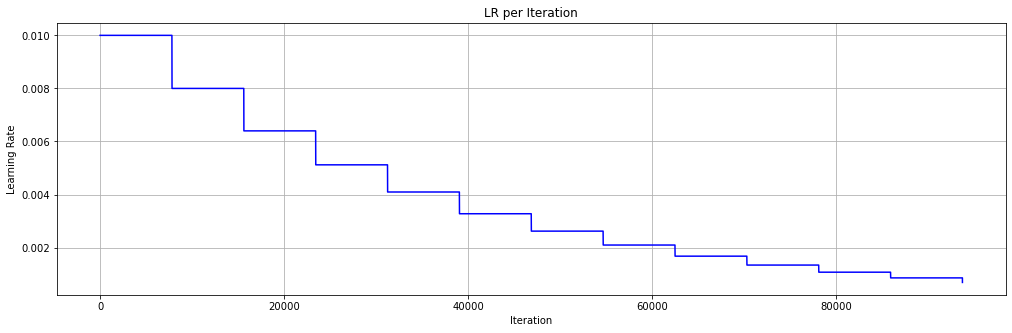

In [14]:
plt.rcParams["figure.figsize"] = (17,5)
plt.rcParams['axes.grid'] = True 

plt.subplot(1,2,1)
plt.plot(x_array, train_cost_arr, 'r', label='train cost')
plt.plot(x_array, test_cost_arr, 'g', label='test cost')
plt.xlabel('EPOCH')
plt.ylabel('Cost')
plt.title('Train(r)/Test(g) Cost vs Epoch')

plt.subplot(1,2,2)
plt.plot(x_array, train_accu_arr, 'r', label='train accu')
plt.plot(x_array, test_accu_arr, 'g', label='test accu')
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')
plt.title('Train(r)/Test(g) ACCURACY vs Epoch')
plt.show()

plt.plot([x for x in range(len(train_lr_arr))], train_lr_arr, 'b', label='lr per iteration')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('LR per Iteration')
plt.show()

<h4><b><u> Codes for testing model with no graph.

In [ ]:
DEVICE = 'cuda:0'
creterion = nn.CrossEntropyLoss().to(DEVICE)

def test_model_no_graph(_model, _test_data_loader, _creterion):
    test_cost = 0
    test_accu = 0
    corrects = 0
    _model.eval()
    print('----------------test----------------')
    for batch_idx, data in enumerate(_test_data_loader):
        x, y = data
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        prediction = _model(x)
        corrects += (prediction.argmax(1) == y).sum().item()
        cost = _creterion(prediction, y).item()
        test_cost += cost/len(test_data_loader)
        test_accu += corrects / len(test_data)

    return test_cost, test_accu

model_loaded = torch.load('../trained_models/___model_name___')    
model_loaded = model_loaded.to(DEVICE)
test_cost, test_accuracy = test_model_no_graph(model_loaded, test_data_loader, creterion)
print('Test Cost: ', test_cost, '\nTest Accuracy', test_accuracy)

<h3> <u> <b> Clear GPU

In [ ]:
#I recommand to restart kernel
#The codes below is the next best thing.

gc.collect()
torch.cuda.empty_cache()